In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

['.DS_Store', 'test', 'train.csv', 'sample_submission.csv']


In [2]:
import matplotlib.pyplot as plt

In [3]:
%%time
train = pd.read_csv('../input/train.csv', dtype={'acoustic_data': np.int16, 'time_to_failure': np.float32})

CPU times: user 1min 46s, sys: 9.74 s, total: 1min 56s
Wall time: 1min 57s


In [4]:
train.head()

,acoustic_data,time_to_failure
0,12,1.4691
1,6,1.4691
2,8,1.4691
3,5,1.4691
4,8,1.4691


In [11]:
train.shape

(629145480, 2)

In [20]:
max_time = int(np.floor(train.shape[0]*1/100))

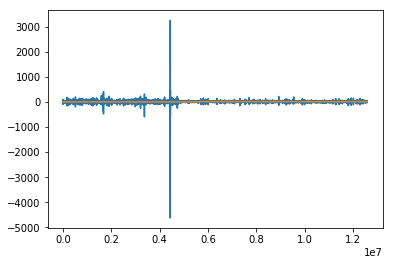

In [21]:
plt.plot(train.acoustic_data[0:max_time])
plt.plot(train.time_to_failure[0:max_time])